In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cinema-ticket/cinemaTicket_Ref.csv


# Overview

![](https://digitalwoods.net/wp-content/uploads/2021/01/Sales-forecast.png)
One of the Major data-driven solutions that ML and Data Science has empowered organizations and businesses is to be able to Forecast and Predict Total Sales.

Some major benefits of forecasting future sales are:
* Sales drives everything else; it is what determines the expense spending plan,i.e the production plan of the organisation.
* Allows film-makers to efficiently allocate resources for future growth and manage their finances.
* Enables continuous strategic planning - By understanding the future rate of sale, the film-makers can improve pricing , product development and advertise accordingly.

In this notebook, we will be utilizing time series analysis and machine learning algorithms such as an XGBRegressor to forecast total sales with this sample dataset.


# 1. Loading Dataset and Initial Preprocessing  

## 1.1 Importing Dependencies 

In [2]:
#preprocessing and visualization modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.style
matplotlib.style.use('bmh')
from matplotlib.pylab import rcParams
import seaborn as sns
from IPython.display import display

#Time series and ML modules
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install pmdarima
from pmdarima import auto_arima
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from calendar import day_name
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore") 

## 1.2 Loading Dataset 

In [3]:
ticket_df = pd.read_csv('../input/cinema-ticket/cinemaTicket_Ref.csv')

In [4]:
ticket_df.head(10)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.000000,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.000000,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.000000,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.000000,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.000000,15,89.982004,2018-05-05,5,2,5
5,1492,71,1050000,7,0,3,0.98,150000.000000,7,714.285714,2018-05-05,5,2,5
6,1492,163,1020000,10,0,3,7.69,102000.000000,10,130.039012,2018-05-05,5,2,5
7,1492,450,750000,5,0,3,1.57,150000.000000,5,318.471338,2018-05-05,5,2,5
8,1492,51,750000,11,0,2,0.95,68181.818182,11,1157.894737,2018-05-05,5,2,5
9,1492,522,600000,4,0,3,1.55,150000.000000,4,258.064516,2018-05-05,5,2,5


In [5]:
#Basic info 
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   film_code     142524 non-null  int64  
 1   cinema_code   142524 non-null  int64  
 2   total_sales   142524 non-null  int64  
 3   tickets_sold  142524 non-null  int64  
 4   tickets_out   142524 non-null  int64  
 5   show_time     142524 non-null  int64  
 6   occu_perc     142399 non-null  float64
 7   ticket_price  142524 non-null  float64
 8   ticket_use    142524 non-null  int64  
 9   capacity      142399 non-null  float64
 10  date          142524 non-null  object 
 11  month         142524 non-null  int64  
 12  quarter       142524 non-null  int64  
 13  day           142524 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 15.2+ MB


In [6]:
#shape 
ticket_df.shape 
#14000 rows with 14 columns

(142524, 14)

## 1.3 Checking for Null Values

In [7]:
ticket_df.isnull().sum()

film_code         0
cinema_code       0
total_sales       0
tickets_sold      0
tickets_out       0
show_time         0
occu_perc       125
ticket_price      0
ticket_use        0
capacity        125
date              0
month             0
quarter           0
day               0
dtype: int64

In [8]:
pd.DataFrame(data = [ticket_df.isna().sum()/ticket_df.shape[0]*100],
             index=["Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Null (%)
film_code,0.000000
cinema_code,0.000000
total_sales,0.000000
tickets_sold,0.000000
tickets_out,0.000000
show_time,0.000000
occu_perc,0.087705
ticket_price,0.000000
ticket_use,0.000000
capacity,0.087705


A very low percentage of null values are present in the dataset so it woudnt hurt to just drop them.

In [9]:
ticket_df.dropna(inplace=True)
ticket_df.isnull().sum()

film_code       0
cinema_code     0
total_sales     0
tickets_sold    0
tickets_out     0
show_time       0
occu_perc       0
ticket_price    0
ticket_use      0
capacity        0
date            0
month           0
quarter         0
day             0
dtype: int64

No more null values are present, so we can proceed.

## 1.4 Checking for Duplicates


In [10]:
print(f"Dataset has {ticket_df.duplicated().sum()} duplicated data")

Dataset has 104 duplicated data


Since we dont have a lot of duplicates, it is fine to drop them.

In [11]:
#dropped all duplicate rows
ticket_df.drop_duplicates(keep='first')

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142519,1569,495,1320000,22,0,2,3.86,60000.0,22,569.948187,2018-11-04,11,4,4
142520,1569,474,1200000,15,0,1,65.22,80000.0,15,22.999080,2018-11-04,11,4,4
142521,1569,524,1060000,8,0,3,9.20,132500.0,8,86.956522,2018-11-04,11,4,4
142522,1569,529,600000,5,0,2,5.00,120000.0,5,100.000000,2018-11-04,11,4,4


In [12]:
def duplicate(df, column):
    if len(df[df[column].duplicated()]) == 0:
        print(f'STATUS: There are no duplicate values in the column of "{column}"')
    else:
        print(f'STATUS: There are {len(df[df[column].duplicated()])} duplicate values in the column of "{column}"')

In [13]:
duplicate(ticket_df,'film_code')

STATUS: There are 142351 duplicate values in the column of "film_code"


In [14]:
duplicate(ticket_df,'cinema_code')

STATUS: There are 142155 duplicate values in the column of "cinema_code"


This is because the same film and and the specific cinema have been repeated many times. Although they present different informations, its going to affect our model. Therefore we  concatenate the film and cinema id with the data that represents **a particular date showing a particular film at a particular cinema**

Before I do that I would also like to change 'date' into datetime object which is essential for time series analysis.

In [15]:
ticket_df['date'] = pd.to_datetime(ticket_df["date"],errors='coerce')

In [16]:
cols = ['film_code','cinema_code','date']
ticket_df['id']=ticket_df[cols].apply(lambda row:'_'.join(row.values.astype(str)), axis=1)

In [17]:
ticket_df.head(2)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,id
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5,1492_304_2018-05-05 00:00:00
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5,1492_352_2018-05-05 00:00:00


In [18]:
#Reordering the dataset and bringing the 'id' column in the front
ticket_df = ticket_df[['id'] + [a for a in ticket_df.columns if a != 'id'] ]

In [19]:
ticket_df.tail(2)

,id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
142522,1569_529_2018-11-04 00:00:00,1569,529,600000,5,0,2,5.00,120000.0,5,100.000000,2018-11-04,11,4,4
142523,1569_486_2018-11-04 00:00:00,1569,486,250000,5,0,1,1.79,50000.0,5,279.329609,2018-11-04,11,4,4


In [20]:
ticket_df.drop_duplicates('id',inplace=True)

In [21]:
duplicate(ticket_df,'id')

STATUS: There are no duplicate values in the column of "id"


## 1.5 Unique values

In [22]:
unique_films = ticket_df['film_code'].nunique()
unique_cinemas = ticket_df['cinema_code'].nunique()
print(f"{unique_films} unique films.")
print(f"{unique_cinemas} unique cinemas ")

48 unique films.
244 unique cinemas 


# 2. Univariate Analysis - Total Sales

As we are trying to forecast sales, total_sales has got to be our Target here or the 'label' as some would like to call it. We further dive into this and analyse it more deeply.

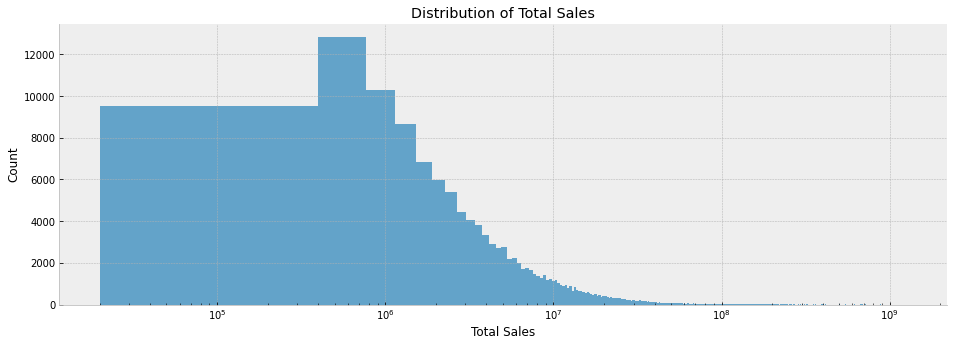

In [23]:
#Visualizing the distribution of total_Sales
t_sales = ticket_df.total_sales.values
ax =sns.displot(t_sales)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5 ,4.5)
plt.title("Distribution of Total Sales")
plt.xlabel('Total Sales')
plt.xscale('log')
plt.show()

At first instance it seems the distribution is heavily skewed at the range of 0 to 10^8 which is a 100 million. 

To understand and analyse it in a better way ,  I will create bins for the total_sales variable and see its distributions across the bins 

**Binning - It is the method of bucketing or discreting values in a large range.**

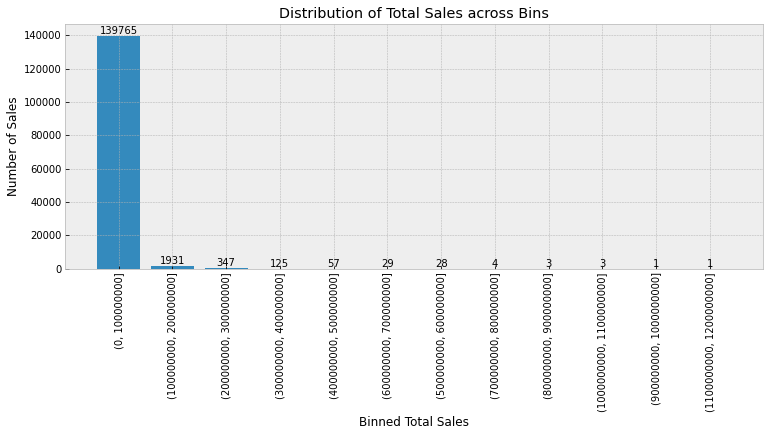

In [24]:
df_uni = ticket_df.copy()
#bins in the range of 0-100m upto 1300000000
bins = np.arange(0,1300000000,100000000)
df_uni['binned']=pd.cut(ticket_df['total_sales'],bins)

#creating a value count df with percentage of total sales in each bin
vc_df = df_uni.reset_index().groupby(['binned']).size().to_frame('count')
vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
vc_df = vc_df.reset_index()
vc_df['binned']=vc_df['binned'].astype('str')

#lets visualize the distributions across the bins 
x = vc_df['binned'].values
y = vc_df['count'].values
plt.bar(x,y)
plt.ylabel('Number of Sales')
plt.xlabel('Binned Total Sales')
plt.title('Distribution of Total Sales across Bins')
plt.xticks(rotation=90)
# code below is for displaying the number of sales on top of the bins 
for i,j in zip(x,y):
    label = "{:.1%}".format(j)
    plt.annotate(int(j),(i,j),textcoords='offset points',xytext=(0,2),ha='center',fontsize=10)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.show()

In [25]:
vc_df

,binned,count,percentage (%)
0,"(0, 100000000]",139765,98.222694
1,"(100000000, 200000000]",1931,1.357049
2,"(200000000, 300000000]",347,0.243861
3,"(300000000, 400000000]",125,0.087846
4,"(400000000, 500000000]",57,0.040058
5,"(600000000, 700000000]",29,0.020380
6,"(500000000, 600000000]",28,0.019678
7,"(700000000, 800000000]",4,0.002811
8,"(800000000, 900000000]",3,0.002108
9,"(1000000000, 1100000000]",3,0.002108


Around 98% of the dataset is in the 1st bin.

## 2.1 IQR - Intequartile Range
 The IQR Range consists of the 50% of the population in its range.
 **IQR * 1.5** is said to consider 99% of the population. The rest 1% is said to be considered as outliers.
 
 The IQR can be defined as the difference between the 75th quantile and the 25th quantile. 
 Therefore IQR = Q3 - Q1
 
 We use this method to identify the outliers and remove them

In [26]:
Q1 = ticket_df['total_sales'].quantile(.25) #25th quantile
print(f"The first quantile is {Q1}")
Q3 = ticket_df['total_sales'].quantile(0.75) #75th quantile
print(f"The third quantile is {Q3}")
IQR = Q3-Q1
print(f"The IQR range is {IQR}")
S = 1.5 * IQR #Threshold

#Upperbound - Anything above this is considered as an outlier
UB = Q3 + S

#Lowerbound - Anything below this is considered as an outlier
LB = Q1 - S

print(f"Valid range for Total_Sales : {LB} <= Total Sales <= {UB}")


The first quantile is 1270000.0
The third quantile is 11100000.0
The IQR range is 9830000.0
Valid range for Total_Sales : -13475000.0 <= Total Sales <= 25845000.0


## 2.2 Empirical Rule
Also known as the **68-95-99.7** rule states that in a normal distirbution:
- 68% of the population lies within 1 * standard deviation of the mean up and down
- 95% of the population lies within 2 * standard deviation of the mean up and down
- 99.7% of the population lies within 3 * standard deviation of the mean up an down 

Anything not within these ranges is considered as an outlier 

In [27]:
mean = ticket_df['total_sales'].mean()
print(f'mean is {mean}')
std = ticket_df['total_sales'].std()
print(f'standard deviation is {std}')
if std>mean:
    print(f"standard deviation is {std/mean} higher than mean")

#simple function to carry out the emperical formula     
def empirical_rule(n=1 ,rt = False):
    UB = mean + (n* std)
    LB = mean - (n * std)
    if rt:
        return UB #returning Upper boundary for future use
    print(f"valid range for {n} std : {LB} <= Total Sales <= {UB}")

empirical_rule(1) #returns 1 * std range
empirical_rule(2) # returns 2 * std range
empirical_rule(3) # returns 3 * std range

#Removing outliers outside the upper bound of 3 * std as they would be considered as outliers for our dataset
UB = empirical_rule(3,rt=True)
ticket_df2=ticket_df[ticket_df['total_sales']<= UB]
print(f"Filtered total sales values <= {UB}")
mean =ticket_df2['total_sales'].mean() 
print(f"mean = {mean}")
std = ticket_df2['total_sales'].std() 
print(f"std  = {std}")
print(f"standard deviation is {std/mean} higher than mean")

mean is 12338325.170870375
standard deviation is 30627056.35678718
standard deviation is 2.4822701568195638 higher than mean
valid range for 1 std : -18288731.185916804 <= Total Sales <= 42965381.52765755
valid range for 2 std : -48915787.542703986 <= Total Sales <= 73592437.88444473
valid range for 3 std : -79542843.89949116 <= Total Sales <= 104219494.24123192
Filtered total sales values <= 104219494.24123192
mean = 9431057.905127015
std  = 14980741.718226833
standard deviation is 1.5884476448907008 higher than mean


We can see that the mean and std has reduced significantly by just filtering less than 0.15% of the values.

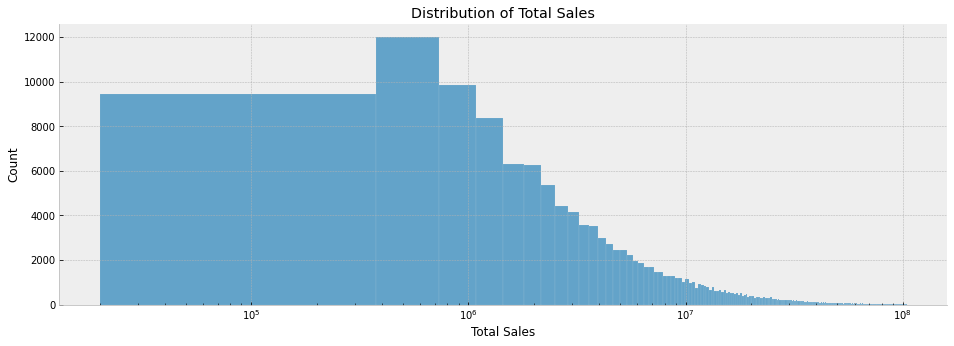

In [28]:
#Visualizing the total sales distribution without the outliers
t_sales = ticket_df2.total_sales.values
ax =sns.displot(t_sales)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5 ,4.5)
plt.title("Distribution of Total Sales")
plt.xlabel('Total Sales')
plt.xscale('log')
plt.show()

Lets see the distribution of the filtered total sales across the bins. 

(Note: Just copy the code from above and replace the df and change the bin upper range by the UB of the std3. <br>
I should have made functions :P )

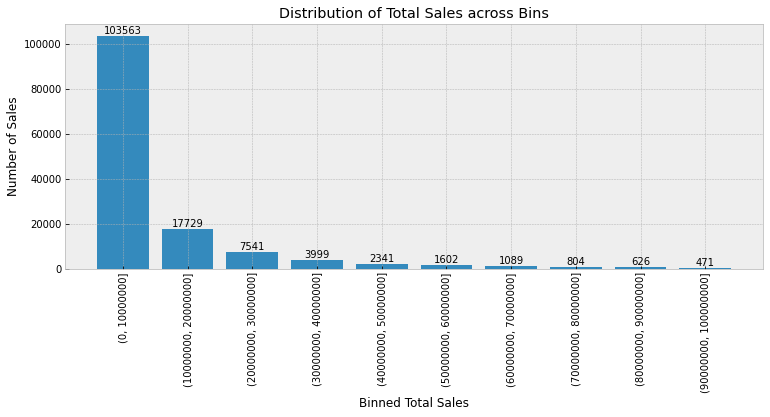

In [29]:
df_uni = ticket_df2.copy()
#bins in the range of 0-10m upto Upper bound
bins = np.arange(0,104219494,10000000)
df_uni['binned']=pd.cut(ticket_df2['total_sales'],bins)

#creating a value count df with percentage of total sales in each bin
vc_df = df_uni.reset_index().groupby(['binned']).size().to_frame('count')
vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
vc_df = vc_df.reset_index()
vc_df['binned']=vc_df['binned'].astype('str')

#lets visualize the distributions across the bins 
x = vc_df['binned'].values
y = vc_df['count'].values
plt.bar(x,y)
plt.ylabel('Number of Sales')
plt.xlabel('Binned Total Sales')
plt.title('Distribution of Total Sales across Bins')
plt.xticks(rotation=90)
# code below is for displaying the number of sales on top of the bins 
for i,j in zip(x,y):
    label = "{:.1%}".format(j)
    plt.annotate(int(j),(i,j),textcoords='offset points',xytext=(0,2),ha='center',fontsize=10)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.show()

**98% of the values from the 0-100m range were actually in the 0-10m range.**

In [30]:
vc_df

,binned,count,percentage (%)
0,"(0, 10000000]",103563,74.097950
1,"(10000000, 20000000]",17729,12.684864
2,"(20000000, 30000000]",7541,5.395485
3,"(30000000, 40000000]",3999,2.861231
4,"(40000000, 50000000]",2341,1.674954
5,"(50000000, 60000000]",1602,1.146210
6,"(60000000, 70000000]",1089,0.779165
7,"(70000000, 80000000]",804,0.575251
8,"(80000000, 90000000]",626,0.447895
9,"(90000000, 100000000]",471,0.336994


## 2.3 Visualization of some other important features

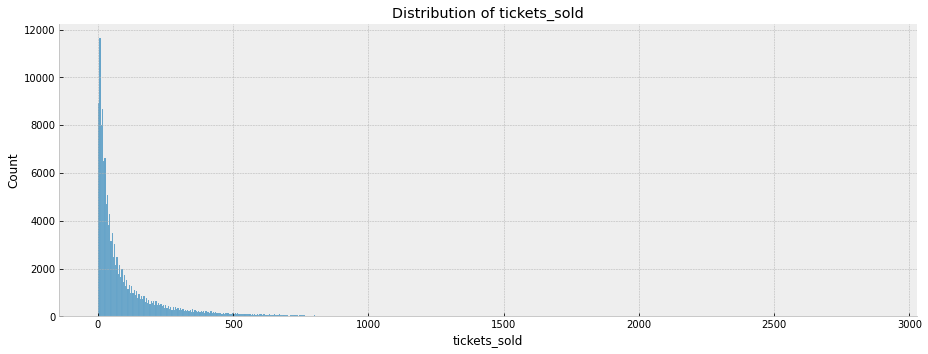

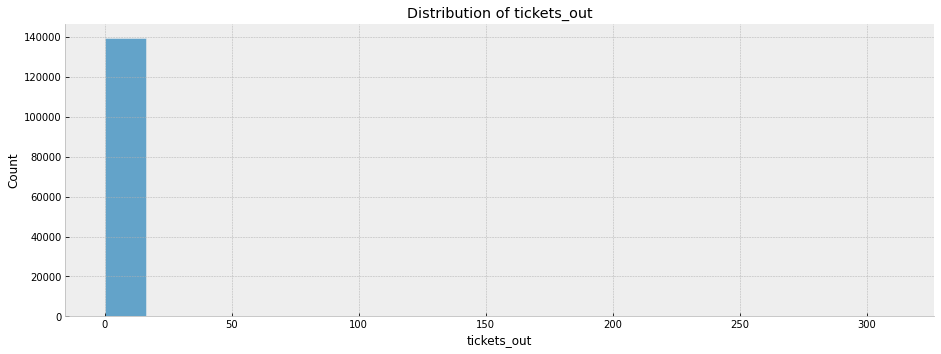

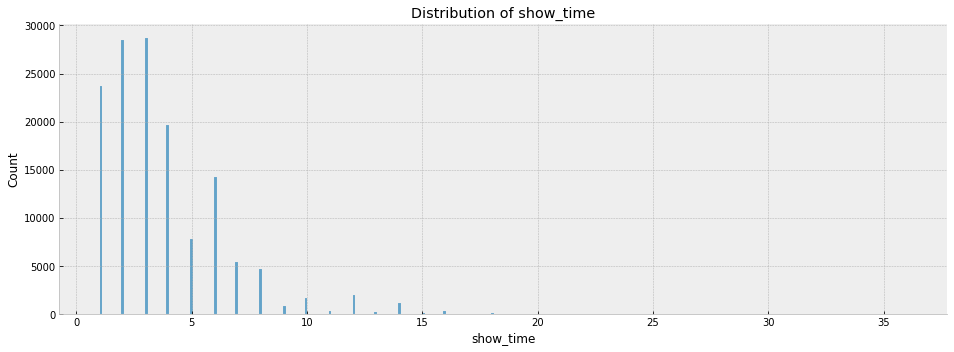

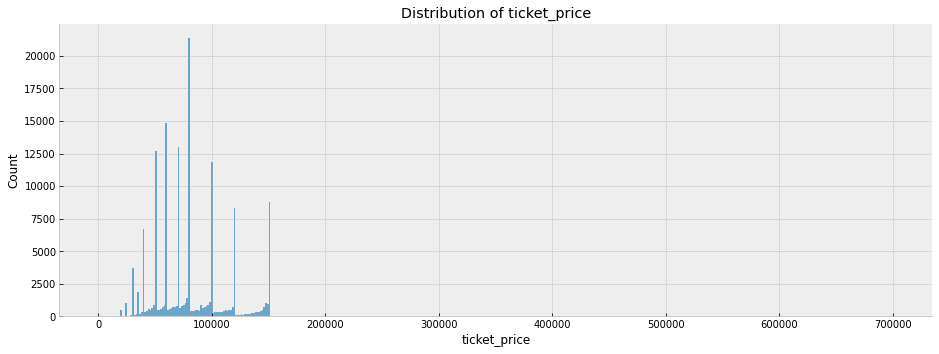

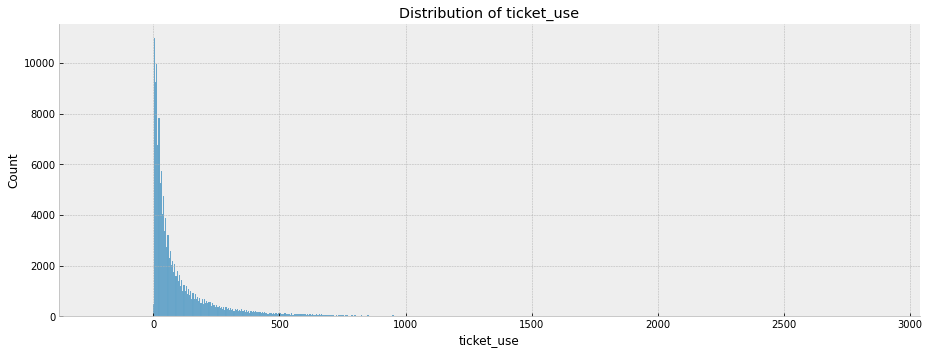

In [31]:
#Ended up making this as a function
def viz(df,col):
    variable = df[col].values
    ax =sns.displot(variable)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15.5 ,4.5)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.show()

viz_cols = ['tickets_sold', 'tickets_out','show_time','ticket_price','ticket_use']    
for col in viz_cols:
    viz(ticket_df2,col)

# 3. Time Series Analysis 
Now we analyse and visualize the total sales across different time periods such as quarterly ,monthly, weekly, and on weekends. 

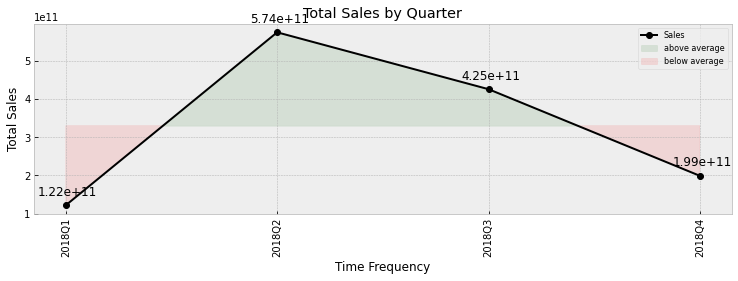

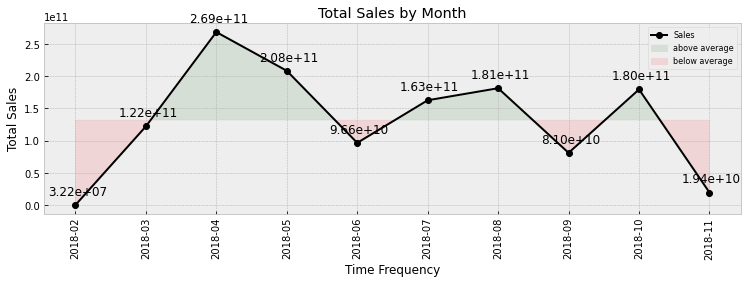

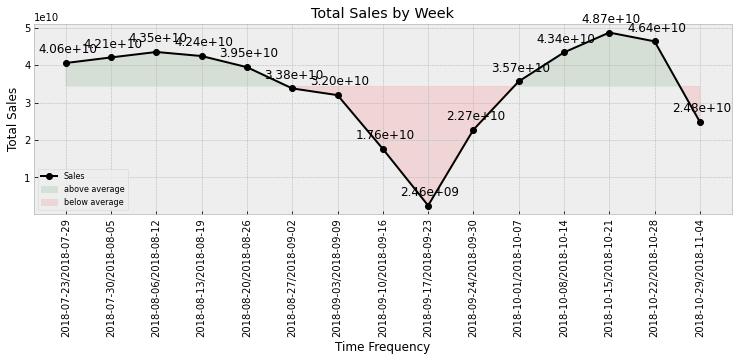

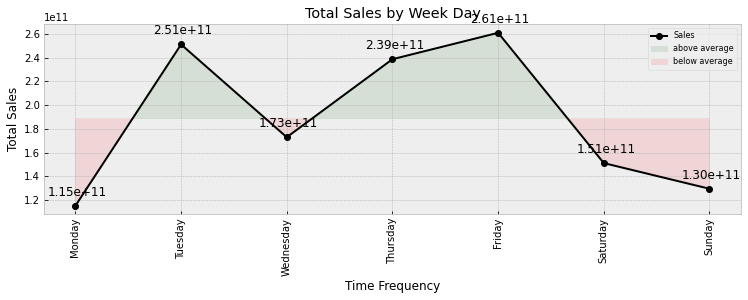

In [32]:
# Defining a fucntion to return an aggregrate by time period 
def aggregate_period(df, period,column, w_mean = False): 
    freq = df.date.dt.to_period(period)
    if w_mean == False:
        s = df.groupby(freq).agg({'total_sales': ['sum']})
        s.columns = ['met']
    else:
        s = df.groupby(freq).agg({column: ['mean']})
        s.columns = [f'met']
    s.reset_index(level=0, inplace=True)
    s.date= s.date.astype(str)
    return s

#Defining a function to return an aggregrate by days of the week
def aggregate_period_weekday(df,column, w_mean= False): 
    freq = df['date'].dt.day_name()
    if w_mean == False:
        s = df.groupby(freq).agg({'total_sales': ['sum']})
        s.columns = ['met']
    else:
        s = df.groupby(freq).agg({column: ['mean']})
        s.columns = [f'met']
    s.reset_index(level=0, inplace=True)
    s.date= s.date.astype(str)
    d = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    s = s.set_index('date').reindex(d).reset_index()
    return s

#Defining a function to visualize the distributions across different time periods 
def viz(df, title,n):
    date = df['date'][-n:] #the latest dates
    count_period =df['met'][-n:] #the latest sales

    plt.plot(date, count_period, linestyle='solid', color='black', marker='o')
    plt.title(f'{title}')
    plt.xlabel('Time Frequency')
    plt.ylabel("Total Sales")
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 3.5)
    #to show the total sales 
    for x,y in zip(date,count_period):
        label = "{:.2e}".format(y)
        plt.annotate((label), # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(2,10), # distance from text to points (x,y)
                     ha='center' , fontsize=12) # horizontal alignment can be left, right or center

    overall_mean = count_period.mean()
    plt.fill_between(date, count_period,overall_mean,where=(count_period>overall_mean),alpha=0.10, interpolate=True, color='DarkGreen')
    plt.fill_between(date, count_period,overall_mean,where=(count_period<overall_mean),alpha=0.10, interpolate=True, color='Red')
    plt.legend(['Sales', 'above average', 'below average'], prop={'size': 8})
    plt.xticks(rotation=90)
    return plt.show()

q = aggregate_period(ticket_df2, 'q','na')
m = aggregate_period(ticket_df2, 'm','na')
w = aggregate_period(ticket_df2, 'w','na')
W = aggregate_period_weekday(ticket_df2,'na')
viz(q ,"Total Sales by Quarter",25)
viz(m ,"Total Sales by Month",25)
viz(w ,"Total Sales by Week",15)
viz(W ,"Total Sales by Week Day",15) 

**Some Critical Insights :**
- Total sales are higher than the above average in the 2nd and 3rd quarter.
- Sales seem to be critically down during the start and the end of the year probably due to New Years and Christmas preparations.
- According to this data, September seems to be unpopular for watching movies in the theatre.
- The pre weekend days do better than the weekends probably since people just want to relax and do chores on the weekends.

# 4. Plotting Time Series 
Analysing the daily total sales and plotting time series techniques to forcast a future sale.

In [33]:
#Aggregrate by Day 
df = aggregate_period(ticket_df2, 'd','na')
df.set_index('date',inplace=True)
df.rename(columns={'met':'Total_Sales'},inplace=True)
df.sample(10)

,Total_Sales
date,
2018-05-24,7425150000
2018-09-25,3004390000
2018-07-26,6481405000
2018-09-27,4064795000
2018-08-22,6547590999
2018-06-21,4548505000
2018-09-26,3062430000
2018-08-27,2991095000
2018-06-09,2320559997


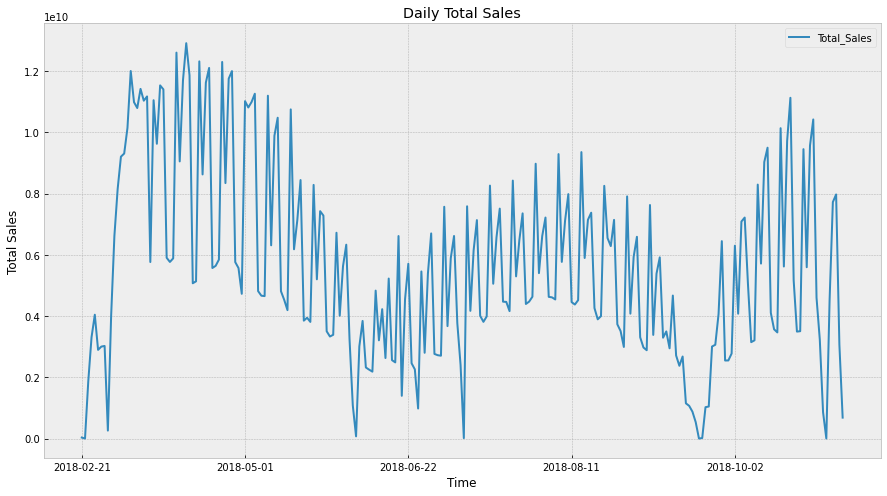

In [34]:
#Visualizing 
df.plot(figsize=(15,8))
plt.title("Daily Total Sales")
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.show()

**Stationary** is an important concept in time series analyse, A dataset is said to be stationary when it exhibits a constant overall behaviour where the statistical properties do not change overtime. Every point must be independant of each other, although the values don't have to necessarily be the same as long it maintains a trend. 

We can clearly see that this dataset is not stationary. Althought just visualizing is not enough, therefore we use the **ADF test** or the **Unit root test** to mthematically prove our dataset is not stationary.


## 4.1 Stationary Check - ADF TEST 
The **ADF** test is a statistical tool to check whether our dataset is stationary or not. 
The ADF degree tells us to what degree can the Null Hypothesis (H0) be rejected.

**Null Hypothesis (H0)** - If failed to be rejected, means that the dataset is not stationary.<br>
**Alternate Hypothesis (H1)** - If 0 is rejected, means that the dataset is stationary.

The ADF test returns a **critical value** also known as  the **'test statistic'**. If this value is lower than the threshold values which are at (1% , 5% , 10%) then we can reject the Null Hypothesis.

In [35]:
#Defining a adf calculator to check the stationary state of the dataset 
def adf_calc(df, target):
    timeseries = df[target]
    result = adfuller(timeseries,autolag='AIC') #the adf function
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('Critical Value: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Lags used: %f' %result[2])
    print('Threshold Values:')
    for key, value in result[4].items(): #critical value dict
        print('%s: %.3f' % (key, value))
adf_calc(df , 'Total_Sales')

Critical Value: -2.252671
p-value: 0.187687
Lags used: 14.000000
Threshold Values:
1%: -3.461
5%: -2.875
10%: -2.574


As the crtical value is greater than the threshold values , **we cannot reject the Null hypothesis(H0)** which states that the dataset is not stationary.

## 4.2 Steps to Normalize the Dataset 
Now we have to take some steps to make our dataset stationary. <br>
Some popular techniques to do this is to use **Difference Transform** or **Logarithmic Transform**.


### 4.2.1 Difference Transform
To eliminate trends and pattern in datasets, we have to stabalize the **mean** of the time series.<br>
Difference transform takes datapoints at current time **'t'** and  and subtracts it with a point before (i.e **'t-n'**) resulting in a dataset between points at time **'t'**.

eg. The First order Difference transform would look something like this

![](https://miro.medium.com/max/640/1*iRp15qVkR0w2WzXAxJg2nA.png)

### 4.2.2 Logarithmic transform
Sometimes, differencing is not enough to remove trends in all non-stationary data. The logarithmic transform takes the log of each point and changes the data into a logarithmic scale. 

It is important to remember that the logarithmic transform must always be followed by the difference transform.

I am going to consider the **log values** to avoid going to higher orde transformtions as our dataset looks pretty far from a stationary dataset.

In [36]:
#finding the log values of total sales
df['total_sales_log'] = np.log(df.Total_Sales)
df.head()

,Total_Sales,total_sales_log
date,,
2018-02-21,32030000,17.282184
2018-02-23,180000,12.100712
2018-03-14,1870938994,21.349706
2018-03-15,3309334994,21.920013
2018-03-16,4043241998,22.120313


In [37]:
# Defining a function to carry out the difference transform
def differencing(df,date, order=1):
    
    #setting date as datetime object and setting it as the index
    df[date]=pd.to_datetime(df[date],errors='coerce')
    df=df.set_index(date)
    
    print(f'The order of the transform is {order}')
    
    
    if order == 1:
        #calculate t-1
        df['t_minus_1']=df['total_sales_log'].shift(periods=1)
        
        #calculate first order dt
        df['target_order_dt']=df['total_sales_log'] - df['t_minus_1']
        
        
    elif order == 2:
        #calculate t-2
        df['t_minus_1']=df['total_sales_log'].shift(periods=1)
        df['first_order_dt']=df['total_sales_log'] - df['t_minus_1'] #returns 1st order
        #have to shift the first order values then subtract that from the first order values
        df['first_order_dt_minus_1']=df['first_order_dt'].shift(periods=1)
        df['target_order_dt']=df['first_order_dt'] - df['first_order_dt_minus_1'] # returns 2nd order dt
        
    elif order == 3:
        #calculate t=3 
        df['t_minus_1']=df['total_sales_log'].shift(periods=1)
        df['first_order_dt']=df['total_sales_log'] - df['t_minus_1'] # returns 1st order
        df['first_order_dt_minus_1']=df['first_order_dt'].shift(periods=1)
        df['second_order_dt']=df['first_order_dt'] - df['first_order_dt_minus_1'] # returns 2nd order
        df['second_order_dt_minus_1']=df['second_order_dt'].shift(periods=1)
        df['target_order_dt']=df['second_order_dt'] - df['second_order_dt_minus_1'] # returns 3rd order
        
    else:
        raise Exception("Order for this particular problem shoud be <=3 ")
   

    #lets visualize the dataset after transforming it
    df[['target_order_dt']].plot(figsize=(15,8))
    plt.title(f'Total Sales After Differencing with Order {order} Against Time')
    plt.xlabel('Time')
    plt.ylabel("Total Sales After Differencing")
    plt.show()
    
    return df
            
        

The order of the transform is 1


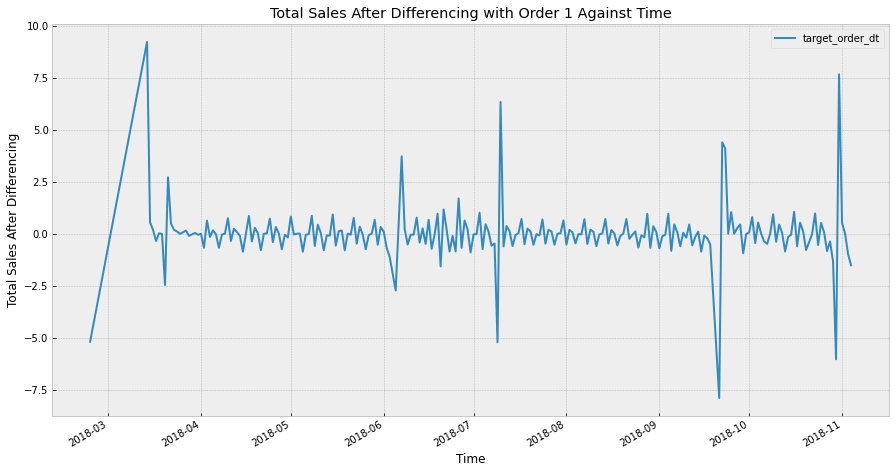

,Total_Sales,total_sales_log,t_minus_1,target_order_dt
date,,,,
2018-02-21,32030000,17.282184,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471
2018-03-14,1870938994,21.349706,12.100712,9.248994
2018-03-15,3309334994,21.920013,21.349706,0.570307
2018-03-16,4043241998,22.120313,21.920013,0.200300
...,...,...,...,...
2018-10-31,4518978000,22.231552,14.543059,7.688493
2018-11-01,7722309998,22.767379,22.231552,0.535828
2018-11-02,7970860000,22.799058,22.767379,0.031679


The order of the transform is 2


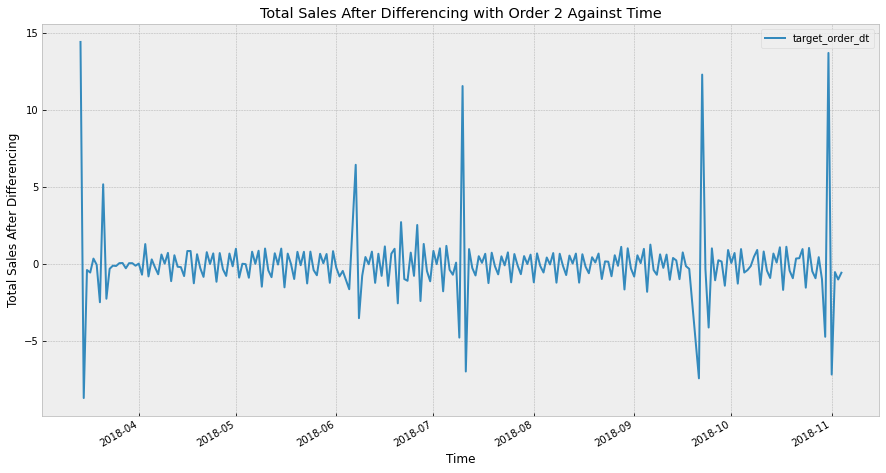

,Total_Sales,total_sales_log,t_minus_1,first_order_dt,first_order_dt_minus_1,target_order_dt
date,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007
...,...,...,...,...,...,...
2018-10-31,4518978000,22.231552,14.543059,7.688493,-6.028757,13.717249
2018-11-01,7722309998,22.767379,22.231552,0.535828,7.688493,-7.152665
2018-11-02,7970860000,22.799058,22.767379,0.031679,0.535828,-0.504149


The order of the transform is 3


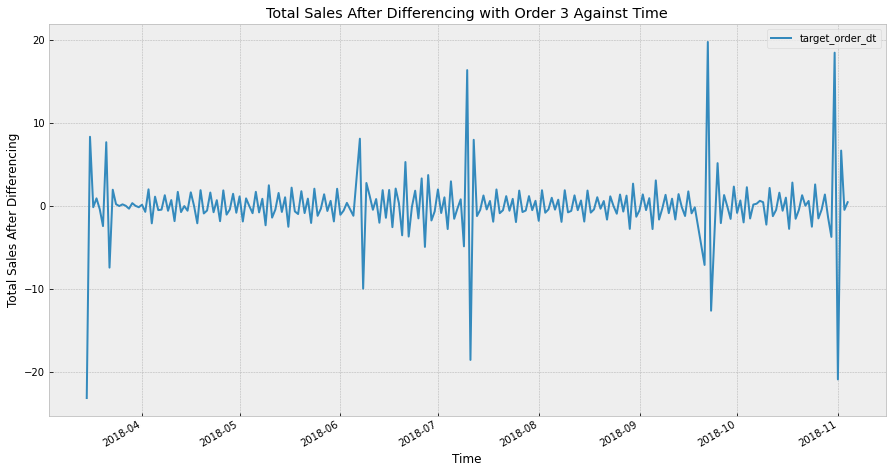

,Total_Sales,total_sales_log,t_minus_1,first_order_dt,first_order_dt_minus_1,second_order_dt,second_order_dt_minus_1,target_order_dt
date,,,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466,NaN,NaN
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687,14.430466,-23.109153
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007,-8.678687,8.308680
...,...,...,...,...,...,...,...,...
2018-10-31,4518978000,22.231552,14.543059,7.688493,-6.028757,13.717249,-4.704206,18.421456
2018-11-01,7722309998,22.767379,22.231552,0.535828,7.688493,-7.152665,13.717249,-20.869914
2018-11-02,7970860000,22.799058,22.767379,0.031679,0.535828,-0.504149,-7.152665,6.648516


In [38]:
df_temp = df.reset_index()
#1st order differencing
df1_dt = differencing(df_temp, 'date', order=1) 
display(df1_dt)
#2nd order differencing
df2_dt = differencing(df_temp, 'date', order=2)
display(df2_dt)
#3rd order differencing
df3_dt = differencing(df_temp, 'date', order=3)
display(df3_dt)



As we can see that first order transformation of the log values for total sales looks more stationary than the original dataset.

In [39]:
df2 = df1_dt.dropna()
print("check stationarity of order 1")
adf_calc(df2, 'target_order_dt')

check stationarity of order 1
Critical Value: -11.317874
p-value: 0.000000
Lags used: 5.000000
Threshold Values:
1%: -3.459
5%: -2.874
10%: -2.574


As the **Critical Value** is greater than the Threshold values, we can consider this dataset as stationary.

# 5. Forecasting with Moving average

**Autocorrelation** and **Partial Autocorrelation** are based on the **Autoregressive process** in which the current value is based on the preceding values. 
While Autocorrelation gives us the indirect relationship of the current value to the specified kth lag value, Partial Autocorrelation gives us the direct relationship with the kth lag value.

**kth lag value** - The number of steps you want to go behind

**Moving Average** - Also known as the **'rolling mean'** is calculated by adding recent prices and then dividing that figure by the number of time periods in the calculation average. It can be an awesome tool to forecast the trend direction.<br>
A **Weighted Moving Average** puts more weight on recent data and less on past data. This can be done by multiplying the weight factor.

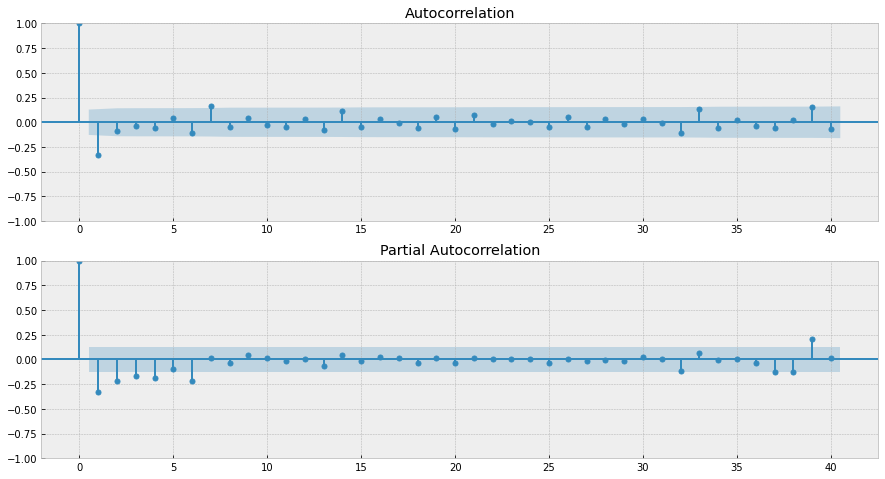

In [40]:
#Visualizing the Autocorrelation and the Partial autocorrelation curves
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df2.target_order_dt,lags=40,ax=ax1) #autocorrealtion curve
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2.target_order_dt,lags=40,ax=ax2) #partialauto curve


In [41]:
# Defining a function to calculate the simple moving average and weighted moving average
def simple_moving_average(arr, window_size, weights=None):
    i = 0
    len_array = len(arr)+1 #as we are going to predict sales for a new day
    answer = [None] * len_array #array thats going to hold answers
    computation = [None] * len_array  #array thats going to hold how the computation took place
    row = window_size
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array len_array andconsider every window size as 3
    while i < len(arr) - window_size + 1:

    # Calculate the average of current window
        if weights == None:
            array_values = arr[i:i+window_size] #sliding the window width in the series
            window_average = round(np.sum(array_values) / window_size, 3) # avg after considering window_width
            answer[row] = window_average #assigning the window avg to the appropriate answer array
            computation[row] = (f" sum({array_values}) / ({window_size})  =  {window_average}")
            row+=1
        else:
            array_values = arr[i:i+window_size]
            array_values_multiplied = [a * b for a, b in zip(array_values, weights)] #multiplied by weight factor
            array_values_multiplied = [round(num, 4) for num in array_values_multiplied]
            window_average = round(np.sum(array_values_multiplied), 4)
            answer[row] = window_average
            computation[row] = (f"sum({array_values_multiplied}) =  {window_average}") 
            row+=1
        # Store the average of current window in moving average list
        moving_averages.append(window_average)
        # Shift window to right by one position
        i += 1
    arr.append(None) #so that it can hold the forecasted value

    #creating a df to compare actual and forecasted values
    d = {'Actual': arr, 'Forecasted':answer, 'Computation':computation}
    df_result = pd.DataFrame(d)

    print(f"Forecasted result for next day: {answer[-1]}")

    df_metric =  df_result.dropna()
    y_actual = df_metric['Actual'].values.tolist()
    y_predicted  = df_metric['Forecasted'].values.tolist()

    return df_result


## 5.1 Simple Moving Average  

In [42]:
index = df.index.tolist()
index.append('2018-11-05') #adding the next day 
arr  = df[['Total_Sales']].values.flatten().tolist() #Total sales in a list format
#no. of raw observations considered for ma. 2 cause acf curve suggests so
window_size = 2 
# weights = [0.2,0.3,0.5] #must add up to 1 (is arbitary)
result_ma = simple_moving_average(arr, window_size, weights=None)
result_ma.index = index
result_ma = result_ma.dropna()
result_ma.tail(10)

Forecasted result for next day: 1874382500.0


,Actual,Forecasted,Computation
2018-10-26,1.041976e+10,7.580779e+09,"sum([5594120000, 9567438000]) / (2) = 75807..."
2018-10-27,4.599490e+09,9.993599e+09,"sum([9567438000, 10419759998]) / (2) = 9993..."
2018-10-28,3.231999e+09,7.509625e+09,"sum([10419759998, 4599489998]) / (2) = 7509..."
2018-10-29,8.594610e+08,3.915744e+09,"sum([4599489998, 3231999000]) / (2) = 39157..."
2018-10-30,2.070000e+06,2.045730e+09,"sum([3231999000, 859461000]) / (2) = 204573..."
2018-10-31,4.518978e+09,4.307655e+08,"sum([859461000, 2070000]) / (2) = 430765500.0"
2018-11-01,7.722310e+09,2.260524e+09,"sum([2070000, 4518978000]) / (2) = 22605240..."
2018-11-02,7.970860e+09,6.120644e+09,"sum([4518978000, 7722309998]) / (2) = 61206..."
2018-11-03,3.065780e+09,7.846585e+09,"sum([7722309998, 7970860000]) / (2) = 78465..."
2018-11-04,6.829850e+08,5.518320e+09,"sum([7970860000, 3065780000]) / (2) = 55183..."


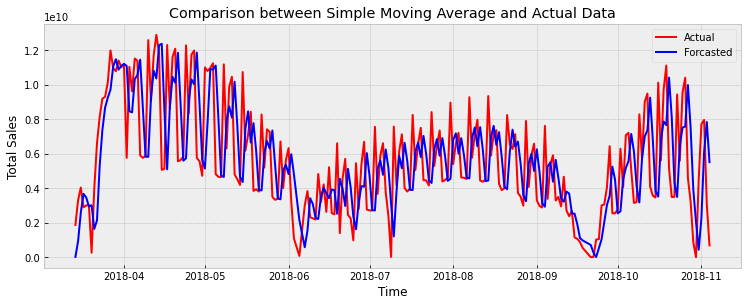

In [43]:
temp_df = result_ma.reset_index()
temp_df['index'] = pd.to_datetime(temp_df['index'],errors='coerce')
result_ma= temp_df.set_index('index')

fig=matplotlib.pyplot.gcf()
fig.set_size_inches(12.5,4.5)
plt.title(f'Comparison between Simple Moving Average and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(result_ma['Actual'],label='Actual',color = 'r')
plt.plot(result_ma['Forecasted'],label='Forcasted', color = 'b')
plt.legend()

## Defining a function to calculate some important metrics to evaluate the algorithms

In [44]:
method_list=[] #going to hold the method
algorithm_list = [] #specific algorithm
rmse_list =[] # root mean squared error
mse_list = [] #mean squared error
mae_list = [] #mean absolute error
r2_list = [] #correlation square -tells us how good does the data fit the line
d = {
    'Method': method_list,
    'Algorithm':algorithm_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2': r2_list
}

def get_metric(actual,predicted,method,algorithm):
    #compute metrics
    mse = mean_squared_error(actual,predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual,predicted)
    r2 = r2_score(actual,predicted)
    
    # append list
    method_list.append(method)
    algorithm_list.append(algorithm)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)


    result = pd.DataFrame(d)
    return result
    

In [45]:
#Simple Moving average Evaluation
actual = result_ma['Actual'].tail(30) #last month 
predicted = result_ma['Forecasted'].tail(30)
method = 'Time Series'
algorithm = 'Simple Moving Average'
get_metric(actual,predicted,method,algorithm)

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,Simple Moving Average,1.340669e+19,3.661515e+09,3.179639e+09,-0.387093


**A negative r2 value is not very attractive as it means that the forecast fits worse than the horizontal line or the mean of the function**

## 5.2 Weighted Moving Average 

In [46]:
index = df.index.tolist()
index.append('2018-11-05') #adding the next day 
arr  = df[['Total_Sales']].values.flatten().tolist() #Total sales in a list format
#no. of raw observations considered for ma. 2 cause acf curve suggests so
window_size = 2 
weights = [0.2,0.3,0.5] #must add up to 1 (is arbitary)
result_ma_weighted = simple_moving_average(arr, window_size, weights=weights)
result_ma_weighted.index = index
result_ma_weighted = result_ma_weighted.dropna()
result_ma_weighted.tail(10)

Forecasted result for next day: 818051500.0


,Actual,Forecasted,Computation
2018-10-26,1.041976e+10,3.989055e+09,"sum([1118824000.0, 2870231400.0]) = 3989055400.0"
2018-10-27,4.599490e+09,5.039416e+09,"sum([1913487600.0, 3125927999.4]) = 5039415599.4"
2018-10-28,3.231999e+09,3.463799e+09,"sum([2083951999.6, 1379846999.4]) = 3463798999.0"
2018-10-29,8.594610e+08,1.889498e+09,"sum([919897999.6, 969599700.0]) = 1889497699.6"
2018-10-30,2.070000e+06,9.042381e+08,"sum([646399800.0, 257838300.0]) = 904238100.0"
2018-10-31,4.518978e+09,1.725132e+08,"sum([171892200.0, 621000.0]) = 172513200.0"
2018-11-01,7.722310e+09,1.356107e+09,"sum([414000.0, 1355693400.0]) = 1356107400.0"
2018-11-02,7.970860e+09,3.220489e+09,"sum([903795600.0, 2316692999.4]) = 3220488599.4"
2018-11-03,3.065780e+09,3.935720e+09,"sum([1544461999.6, 2391258000.0]) = 3935719999.6"
2018-11-04,6.829850e+08,2.513906e+09,"sum([1594172000.0, 919734000.0]) = 2513906000.0"


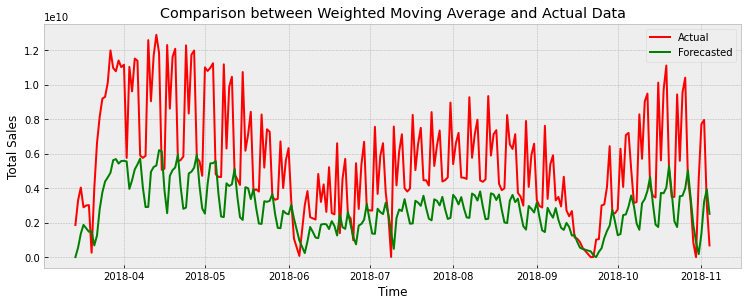

In [47]:
#Lets visualize the weighted moving average 
temp_df = result_ma_weighted.reset_index()
temp_df['index'] = pd.to_datetime(temp_df["index"],errors='coerce')
result_ma_weighted = temp_df.set_index('index')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between Weighted Moving Average and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(result_ma_weighted.Actual,label = 'Actual', color='r' )
plt.plot(result_ma_weighted['Forecasted'],label = 'Forecasted', color='g' )
plt.legend()

In [48]:
#Evaluating the weighted moving average 
actual = result_ma_weighted['Actual'].tail(30) 
predicted = result_ma_weighted['Forecasted'].tail(30)
method = 'Time Series'
algorithm = 'Weighted Moving Average'
get_metric(actual, predicted, method, algorithm)

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,Simple Moving Average,1.340669e+19,3.661515e+09,3.179639e+09,-0.387093
1,Time Series,Weighted Moving Average,1.711698e+19,4.137267e+09,3.139920e+09,-0.770970


**The weighted moving average has performed even worse.**

# 6. Forecasting with ARIMA
Also known as Autoregressive Integrated Moving Average is a model that uses differencing to convert the non statonary dataset into a stationary one. <br>
It uses **Autocorrelations** and **moving averages** over residual errors in the data to forecast future values.


## 6.1 Finding the Best parameters for our ARIMA model
Some important parameters are:
- 'p': Number of time lags
- 'd': differencing order
- 'q': order of the moving averages or size of the moving average window 
- 'm': time frequency, i.e 12 for a month 


In [49]:
auto_arima_fit = pm.auto_arima(df.Total_Sales, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             seasonal=False, trace=True, error_action='ignore', suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10750.720, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10815.731, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10788.290, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10756.123, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10813.733, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10752.129, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10739.181, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10749.187, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10751.732, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10744.299, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10757.280, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10732.395, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10712.241, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] i

In [50]:
model = ARIMA(df.Total_Sales, order=(3,1,2))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Total_Sales   No. Observations:                  234
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5348.988
Date:                Fri, 23 Sep 2022   AIC                          10709.975
Time:                        02:35:50   BIC                          10730.681
Sample:                             0   HQIC                         10718.325
                                - 234                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8799      0.053     16.637      0.000       0.776       0.984
ar.L2         -0.3481      0.070     -4.951      0.000      -0.486      -0.210
ar.L3         -0.3199      0.061     -5.205      0.0

## ARIMA Evaluation Metrics
As for evaluating the ARIMA model, I am going to be looking at the **'AIC**' and **'BIC'** values. These are important statistical criteria that helps us evaluate almost any model.

What are they ?

The formula for AIC goes something like this :**2k-2l** where, <br>
**k** --> is the number of parameters or lags <br>
**l** --> is the log likelihood which suggests how good the model fits our data <br>
Therefore a **lower AIC** means that the model uses **lesser parameters** and a **higher l** due to the - sign which is what we want form our model.

Similarly the formula for 'BIC' is **ln(n)k -2l** , where the only difference is that it also accounts for the number of samples used i.e **(n)**. <br>
Therefore a lower BIC means that the model uses **lesser parameters** , **lesser samples** and a **higher l** due to the - sign which is what we want form our model.

## 6.2 Residual Plot 
Plotting the residual which is the difference between the predicted data and the actual data allows us to visualize how well the model fit our data <br>
If the graph has a lot of ups and downs that basically means that there is a lot of noise, so the model is not a very good fit for our data.

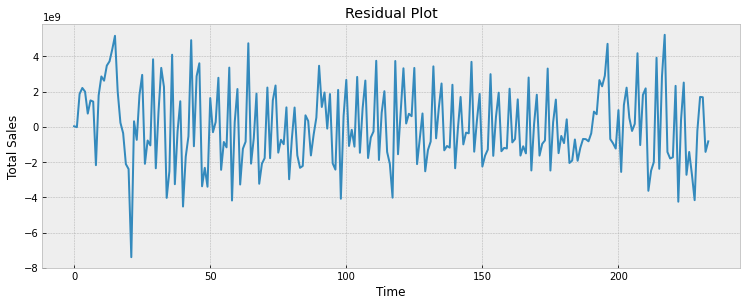

In [51]:
residuals = pd.DataFrame(results.resid)
temp_df = residuals.reset_index()
temp_df['date']=pd.to_datetime(temp_df['date'],errors='coerce')
residuals =temp_df.set_index('date')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel("Total Sales")
plt.plot(residuals.values )


In [52]:
residuals.describe()

,0
count,2.340000e+02
mean,3.766651e+07
std,2.212065e+09
min,-7.388977e+09
25%,-1.542946e+09
50%,-3.472413e+08
75%,1.846770e+09
max,5.213666e+09


Although the noise is mitigated, there are some major fluctuations in the model. 

## 6.3 Prediction Plot 

Visualizing how well the models predicted value fits the actual data 

In [53]:
#defining a function to always reset time as the index after converting it a datetime object
def index_time(df, attribute):
    temp = df.reset_index()
    temp[attribute] = pd.to_datetime(temp[attribute],errors='coerce')
    df = temp.set_index(attribute)
    return df

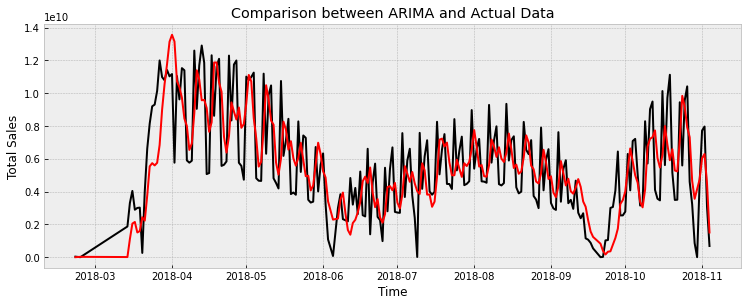

In [54]:
#plotting 
index_list=df.index.tolist()
preds= results.predict(0,233)
preds= preds.set_axis(index_list)
preds=preds.to_frame()
preds=index_time(preds,'index')#the pred values
df = index_time(df,'date') #the actual values

fig=matplotlib.pyplot.gcf()
fig.set_size_inches(12.5,4.5)
plt.title(f'Comparison between ARIMA and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(df.Total_Sales[:234],label='Actual', color = 'black')
plt.plot(preds,label = 'Predicted' , color = 'r')

The ARIMA model is atleast fitting the data better than the simple moving averages.

## 6.4 Forecasting 

In [55]:
#Defining a function to forecast future sales with the model
def get_forecast_values(df, N =30):
    last_date = df.reset_index().at[len(df)-1,'date'] #extracting the last date
    print(f"The last date is: {last_date}")
    forecast_date = pd.to_datetime(last_date) + pd.DateOffset(days=1)
    print(f"start forcast date: {forecast_date}")
    forecast = results.forecast(steps=N) #forecasting for N days 
    forecast_index = pd.date_range(start=forecast_date, periods=N)
    df_forecast = pd.DataFrame({'forecast':forecast.values},index=forecast_index)
    return df_forecast 

#Forecasting the Total sales for the next 30 days using the ARIMA Model
df_forecast = get_forecast_values(df,N = 30) 
df_forecast

The last date is: 2018-11-04 00:00:00
start forcast date: 2018-11-05 00:00:00


,forecast
2018-11-05,2.261784e+08
2018-11-06,1.453755e+09
2018-11-07,3.455084e+09
2018-11-08,4.934891e+09
2018-11-09,5.147710e+09
2018-11-10,4.179733e+09
2018-11-11,2.780589e+09
2018-11-12,1.818330e+09
2018-11-13,1.768262e+09
2018-11-14,2.506682e+09


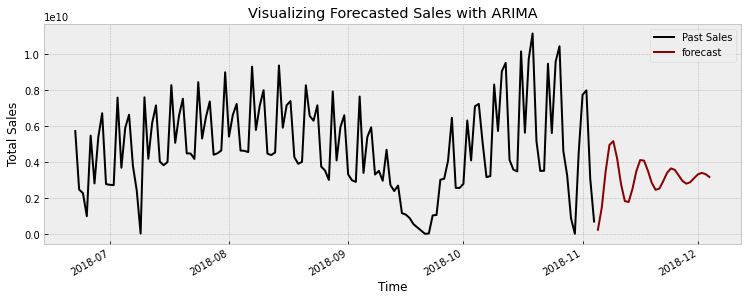

In [56]:
#visualizing the forecasted values
def forecast_plot(df, df_forecast, method):
    ci = df_forecast.values
    ax = df[100:].Total_Sales.plot(label='Past Sales', color ='black', figsize=(20, 15))
    df_forecast.plot(ax=ax,label='Forecasted Sales',color='darkred')
#     ax.fill_between(df_forecast.index,
#                     ci[:,-1],
#                     ci[:,0], color='g', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 4.5)
    plt.legend()
    
    plt.title(f'Visualizing Forecasted Sales with {method}')
    plt.xlabel('Time')
    plt.ylabel("Total Sales")
    return plt.show()

forecast_plot(df, df_forecast, 'ARIMA')

In [57]:
#evaluating the model with metrics 
ar_actual = df['Total_Sales'][:30] 
ar_predicted = results.predict()[:30]
ar_algorithm = 'ARIMA'
ar_method = 'Time Series'
get_metric(ar_actual,ar_predicted,ar_method,ar_algorithm)

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,Simple Moving Average,1.340669e+19,3.661515e+09,3.179639e+09,-0.387093
1,Time Series,Weighted Moving Average,1.711698e+19,4.137267e+09,3.139920e+09,-0.770970
2,Time Series,ARIMA,7.127937e+18,2.669820e+09,2.131719e+09,0.553647


The R2 value is pretty good and the MSE is the lowest.

## 7. Forecasting with SARIMAX 
Tthe concept is pretty similar to the **'ARIMA' model** above except for the fact that is considers the seasonal factor into it calculations.

## 7.1 Finding Optimal Parameters 

In [58]:
auto_sarimax_fit = pm.auto_arima(df.Total_Sales, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             seasonal=True,d=None,D=1, trace=True, error_action='ignore', suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10445.621, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10359.840, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10444.061, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10395.094, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10354.922, Time=0.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=10429.369, Time=0.33 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=10353.225, Time=0.61 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=10360.993, Time=0.20 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

In [59]:
#Training the model with the optimal parameters 
model = SARIMAX(df.Total_Sales,order=(3, 0, 3),
              seasonal_order=(2, 1, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41381D+08    |proj g|=  1.83548D+10


 This problem is unconstrained.



At iterate    5    f=  3.05601D+02    |proj g|=  2.13592D+04

At iterate   10    f=  5.73085D+01    |proj g|=  1.11221D+03

At iterate   15    f=  2.44245D+01    |proj g|=  5.78660D+01

At iterate   20    f=  1.96388D+01    |proj g|=  1.67566D+00

At iterate   25    f=  1.93156D+01    |proj g|=  1.07342D-01

At iterate   30    f=  1.92927D+01    |proj g|=  4.20512D-01

At iterate   35    f=  1.92538D+01    |proj g|=  3.89150D-01

At iterate   40    f=  1.92499D+01    |proj g|=  7.61864D-02

At iterate   45    f=  1.92418D+01    |proj g|=  1.19527D-01

At iterate   50    f=  1.92309D+01    |proj g|=  7.26376D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Total_Sales   No. Observations:                  234
Model:             SARIMAX(3, 0, 3)x(2, 1, [], 12)   Log Likelihood               -4500.039
Date:                             Fri, 23 Sep 2022   AIC                           9018.079
Time:                                     02:37:00   BIC                           9047.536
Sample:                                          0   HQIC                          9030.006
                                             - 234                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8712      0.156     11.993      0.000       1.565       2.177
ar.L2         -1.4955      0.238     -6.278      0.000      -1.962      -1.029
ar.L3          0.5109      0.121      4.213      0.000       0.273       0.749
ma.L1         -1.7816      0.189     -9.419      0.000      -2.152      -1.411
ma.L2          1.0983      0.328      3.353      0.001       0.456       1.740
ma.L3         -0.0553      0.190     -0.290      0.771      -0.428       0.318
ar.S.L12      -0.5250      0.094     -5.614      0.000      -0.708      -0.342
ar.S.L24      -0.1434      0.112     -1.279      0.201      -0.363       0.076
sigma2      8.117e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.35   Prob(JB):                         0.27
Heteroskedasticity (H):               0.99   Skew:                             0.02
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+55. Standard errors may be unstable.
"""

## 7.2 Comparing the Predicted Values with the Actual Values 

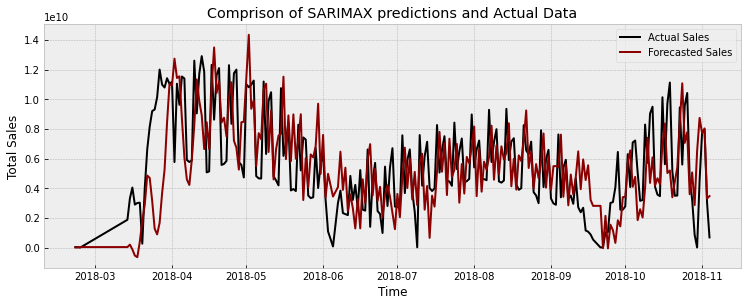

In [60]:
index_list = df.index.tolist()
preds = results.predict(0,233)
preds= preds.set_axis(index_list)
preds = preds.to_frame()
preds = index_time(preds, 'index')
df = index_time(df , 'date')


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5,4.5)
plt.title("Comprison of SARIMAX predictions and Actual Data")
plt.xlabel("Time")
plt.ylabel("Total Sales")
plt.plot(df.Total_Sales[:234],label='Actual Sales' , color = 'k')
plt.plot(preds, label="Forecasted Sales", color = 'darkred')
plt.legend()

## 7.3 Forecasting the Sales for next month 

In [61]:
df_forecast = get_forecast_values(df, N =30)
df_forecast

The last date is: 2018-11-04 00:00:00
start forcast date: 2018-11-05 00:00:00


,forecast
2018-11-05,9.628630e+08
2018-11-06,3.345330e+09
2018-11-07,6.055586e+09
2018-11-08,3.752010e+09
2018-11-09,5.898176e+09
2018-11-10,2.529469e+09
2018-11-11,3.059822e+09
2018-11-12,5.588223e+09
2018-11-13,5.263716e+09
2018-11-14,5.921008e+09


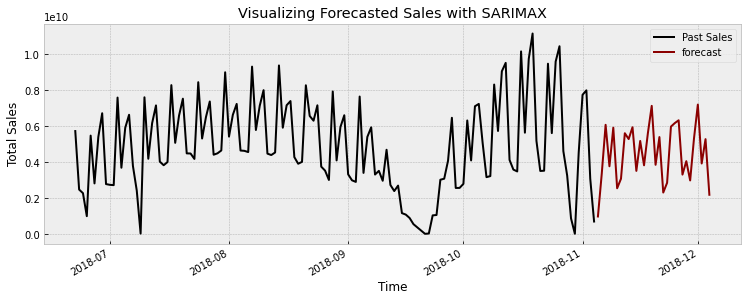

In [62]:
#visualize the forecast 
forecast_plot(df, df_forecast,'SARIMAX')

In [63]:
#adding it to the evaluation table 
sr_actual = df['Total_Sales'][:30] 
sr_predicted = results.predict()[:30]
sr_algorithm = 'SARIMAX'
sr_method = 'Time Series'
get_metric(sr_actual,sr_predicted,sr_method,sr_algorithm)

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,Simple Moving Average,1.340669e+19,3.661515e+09,3.179639e+09,-0.387093
1,Time Series,Weighted Moving Average,1.711698e+19,4.137267e+09,3.139920e+09,-0.770970
2,Time Series,ARIMA,7.127937e+18,2.669820e+09,2.131719e+09,0.553647
3,Time Series,SARIMAX,1.934418e+19,4.398201e+09,3.374759e+09,-0.211337


Has not performed than the 'ARIMA' model.

# 8. Forecasting with Machine Learning Algorithms 

Out of so many ML Algorithms I am going to pick some that I feel would work really well for this data. <br>
All of these are complicated algorithms, although, from my personal experience I have put them in different standards.
- Linear Regression - Standard and starighforward 
- Random Forest Regressor - A bit more deep and complicated 
- XGB Regressor - More on the advanced side. 


## 8.1 Defining some important functions to carry out tasks 

In [64]:
df2.columns

Index(['Total_Sales', 'total_sales_log', 't_minus_1', 'target_order_dt'], dtype='object')

In [65]:
#Defining a function to assemble the modified df
#Note - This time I am going to use the df with the first order differencing that is stationary 
# Considering 5 lags for my data 
def get_data():
    df2 = df.copy()
    df2['lag_1'] =  df2['Total_Sales'].shift(periods=1)
    df2['lag_2'] =  df2['Total_Sales'].shift(periods=2)
    df2['lag_3'] =  df2['Total_Sales'].shift(periods=3)
    df2['lag_4'] =  df2['Total_Sales'].shift(periods=4)
    df2['lag_5'] =  df2['Total_Sales'].shift(periods=5)
    df2 = df2.dropna()
    df2.drop('total_sales_log', axis=1 ,inplace=True)
    return df2

# Function to split the dataset into train and test sets
def train_test_split(df2, n_test):
    x_train = df2.iloc[:-n_test , 1:]  # removing last 30 days and total_sales col
    y_train = df2.iloc[:-n_test , :1] # removing last 30 days and only taking total_Sales col
    x_test = df2.iloc[-n_test: , 1:]  # considering last 30 days without total sales
    y_test = df2.iloc[-n_test: , :1]  # total sales of last 30 days
    
    return x_train, y_train, x_test, y_test

#Giving me a worse value
# #Defining a scale function 
# def Scale_features(x_train,x_test):
#     scaler = StandardScaler()
#     x_train=scaler.fit_transform(x_train)
#     X_test= scaler.transform(x_test)
#     return x_train , x_test

#Defining a function to train the models
def model_train(x_train, y_train, model, model_params):
    if model == 'XGB':
        print("Using XGB model")
        model = model_params #specified parameters
    elif model == 'RFR':
        print("Using RFR model")
        model = model_params
    else:
        print("Using Linear Regression model")
        model = model_params
    
    # fit model
    model = model.fit(x_train, y_train)
    
    #predicted y_train values
    y_train_pred = model.predict(x_train)
    return model , y_train_pred

#defining a function to predict y_test values
def test_preds(model_fit,x_test):
    ypred = model_fit.predict(x_test)
    return ypred

#Defining a function to evaluate the models 
def get_metrics_ml(model_fit,x_test,y_test,model):
    ypred = test_preds(model_fit,x_test)
    #compute metrics
    mse = mean_squared_error(y_test,ypred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,ypred)
    r2 = r2_score(y_test,ypred)
    
    method = 'Machine Learning'
    algorithm = model
    
    # append list
    method_list.append(method)
    algorithm_list.append(algorithm)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)


    result = pd.DataFrame(d)
    return result
    
    

## 8.2 Training the models and Evaluating them

In [66]:
df2 = get_data()

#splitting data
x_train, y_train, x_test, y_test = train_test_split(df2, 30)

# #feature scaling
# x_train, x_test = Scale_features(x_train,x_test)

#Fitting RandomForest Regressor
model_fit, y_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=100))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=100)')

model_fit, y_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=200))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=200)')

model_fit, y_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=300))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=300)')

#Fitting XGB Regressor
model_fit, y_train_pred_XGB = model_train(x_train, y_train, 'XGB', XGBRegressor(objective='reg:squarederror', random_state=0))
result = get_metrics_ml(model_fit, x_test, y_test, 'XGBRegressor')


#Fitting Linear Regression Model
model_fit, y_train_pred_XGB = model_train(x_train, y_train, 'LR', LinearRegression())
result = get_metrics_ml(model_fit, x_test, y_test, 'Linear Regression')

result


Using RFR model
Using RFR model
Using RFR model
Using XGB model
Using Linear Regression model


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,Simple Moving Average,1.340669e+19,3.661515e+09,3.179639e+09,-0.387093
1,Time Series,Weighted Moving Average,1.711698e+19,4.137267e+09,3.139920e+09,-0.770970
2,Time Series,ARIMA,7.127937e+18,2.669820e+09,2.131719e+09,0.553647
3,Time Series,SARIMAX,1.934418e+19,4.398201e+09,3.374759e+09,-0.211337
4,Machine Learning,RFR(n_estimators=100),7.716221e+18,2.777809e+09,2.402536e+09,0.201658
5,Machine Learning,RFR(n_estimators=200),7.470949e+18,2.733304e+09,2.339553e+09,0.227035
6,Machine Learning,RFR(n_estimators=300),7.442448e+18,2.728085e+09,2.335873e+09,0.229984
7,Machine Learning,XGBRegressor,8.418149e+18,2.901405e+09,2.344283e+09,0.129035
8,Machine Learning,Linear Regression,9.677848e+18,3.110924e+09,2.918928e+09,-0.001297


In [67]:
#Using cross validation to make sure there was no overfitting
x_cv = df2.iloc[: , 1:]
y_cv = df2.iloc[: , :1]
rmodel =  RandomForestRegressor(random_state=0, n_estimators=300)
scores = cross_val_score(rmodel, x_cv, y_cv, cv=5)
scores
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

xgbmod = XGBRegressor(objective='reg:squarederror', random_state=0)
x_scores = cross_val_score(xgbmod,x_cv, y_cv, cv=5)
x_scores
print("%0.3f accuracy with a standard deviation of %0.3f" % (x_scores.mean(), x_scores.std()))

0.385 accuracy with a standard deviation of 0.301
0.276 accuracy with a standard deviation of 0.345


## 8.3 Forecasting Sales with the ML models
I am going to consider the 'RFR' and 'XGBRegresor' models for this as the Linear Regression did not perform that well. 

In [68]:
#Setting up the start_date for forecasting 
def get_forecast_date(df):
    forecast_date = df.index[-1] + pd.DateOffset(days=1)
    return forecast_date

# Defining a function to append row values to the forecasted days
def append_row(df):
    #adding a nan value for the forecast date and  we consider last 5 sales as we have 5 lags
    new_row = np.flip(np.append(df.Total_Sales[-5:].values, np.nan)) 
    forecast_date = get_forecast_date(df)
    # add new rows with specified index name
    df.loc[forecast_date] = new_row
    return df, forecast_date

#Defining a function to forecast total sales for the next day
def model_forecast(model_fit, df):
    new_row = np.flip(df.Total_Sales[-5:].values) #last 5 sales
    ypred = model_fit.predict([new_row.tolist()])
    df, forecast_date = append_row(df)
    df.at[forecast_date, 'Total_Sales'] = ypred #the ypred will 
    return df

#Definig a function to forecast total sales for a certain period 
def model_forecast_n(n, model_fit, df):
    for i in range(n):
        df = model_forecast(model_fit, df)
    return df

### 8.3.1 RandomForestRegressor

In [69]:
df2 = get_data()
forecast_date = get_forecast_date(df2)
print(forecast_date)
x_train, y_train, x_test, y_test = train_test_split(df2, 30)
model_fit, y_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=300))
df2 = model_forecast_n(30, model_fit, df2)
df2[-30:]

2018-11-05 00:00:00
Using RFR model


,Total_Sales,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,
2018-11-05,4.691958e+09,6.829850e+08,3.065780e+09,7.970860e+09,7.722310e+09,4.518978e+09
2018-11-06,5.167676e+09,4.691958e+09,6.829850e+08,3.065780e+09,7.970860e+09,7.722310e+09
2018-11-07,5.289846e+09,5.167676e+09,4.691958e+09,6.829850e+08,3.065780e+09,7.970860e+09
2018-11-08,6.518204e+09,5.289846e+09,5.167676e+09,4.691958e+09,6.829850e+08,3.065780e+09
2018-11-09,5.425749e+09,6.518204e+09,5.289846e+09,5.167676e+09,4.691958e+09,6.829850e+08
2018-11-10,5.303138e+09,5.425749e+09,6.518204e+09,5.289846e+09,5.167676e+09,4.691958e+09
2018-11-11,5.120131e+09,5.303138e+09,5.425749e+09,6.518204e+09,5.289846e+09,5.167676e+09
2018-11-12,4.942827e+09,5.120131e+09,5.303138e+09,5.425749e+09,6.518204e+09,5.289846e+09
2018-11-13,5.767961e+09,4.942827e+09,5.120131e+09,5.303138e+09,5.425749e+09,6.518204e+09


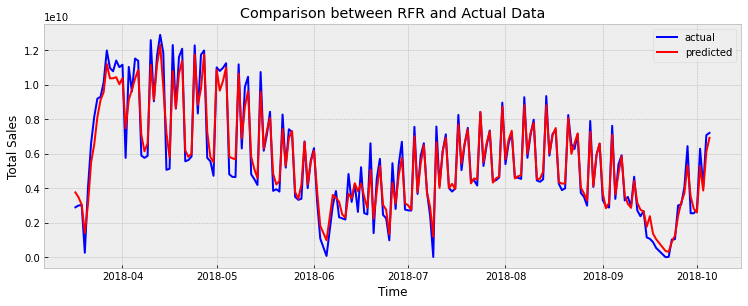

In [70]:
#visualizng how well the predicted RFR predicted sales fit with the data and the forecasted sales
actual = get_data().iloc[:-30 ]
index_list = actual.index.tolist()
prediction = y_train_pred_RFR
prediction = pd.DataFrame({'prediction': prediction}, index=index_list)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between RFR and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(actual.Total_Sales, label = 'actual', color='b' )
plt.plot(prediction, label = 'predicted', color='r' )
plt.legend()

We can see that how well the model has fit the data 

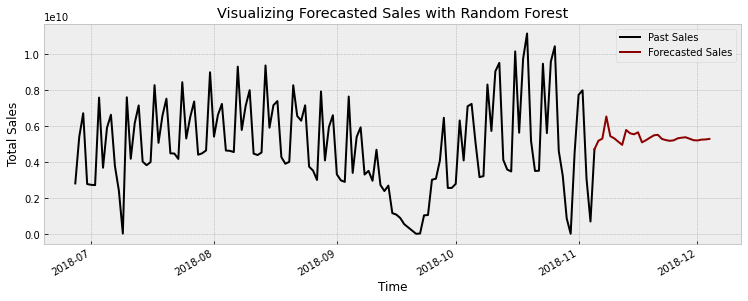

In [71]:
#visualizing the forecastes sales
df_actual= df2[['Total_Sales']].loc[:forecast_date]
df_forecast = df2['Total_Sales'].loc[forecast_date:]
# df_forecast = df_forecast.rename(columns= {'Total_Sales':'Forecasted'})
forecast_plot(df_actual, df_forecast,'Random Forest')


### 8.3.2 XGBRegressor

In [72]:
df2=get_data()

forecast_date=get_forecast_date(df2)
print(f"{forecast_date}")
x_train, y_train, x_test, y_test = train_test_split(df2, 30)
model_fit,y_train_pred_XGB  = model_train(x_train.values, y_train.values, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=0))
df2 = model_forecast_n(30, model_fit, df2)
df2

2018-11-05 00:00:00
Using XGB model


,Total_Sales,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,
2018-03-17,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05,3.203000e+07
2018-03-18,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05
2018-03-19,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09
2018-03-20,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09
2018-03-21,4.006255e+09,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09
...,...,...,...,...,...,...
2018-11-30,8.265844e+09,4.662466e+09,4.174262e+09,5.356689e+09,7.327450e+09,6.762630e+09
2018-12-01,6.728318e+09,8.265844e+09,4.662466e+09,4.174262e+09,5.356689e+09,7.327450e+09
2018-12-02,7.279214e+09,6.728318e+09,8.265844e+09,4.662466e+09,4.174262e+09,5.356689e+09


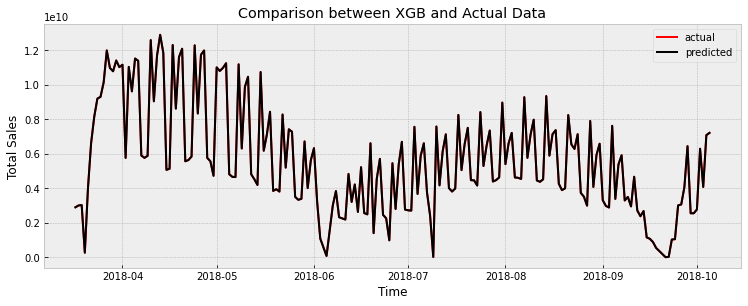

In [73]:
#visualizng how well the predicted RFR predicted sales fit with the data and the forecasted sales
actual = get_data().iloc[:-30 ]
index_list = actual.index.tolist()
prediction = y_train_pred_XGB
prediction = pd.DataFrame({'prediction': prediction}, index=index_list)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between XGB and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(actual.Total_Sales, label = 'actual', color='r' )
plt.plot(prediction, label = 'predicted', color='k' )
plt.legend()

ML predicted training data seems to always be very accurate.  Although it doesnt mean its going to do this well with unseen data.

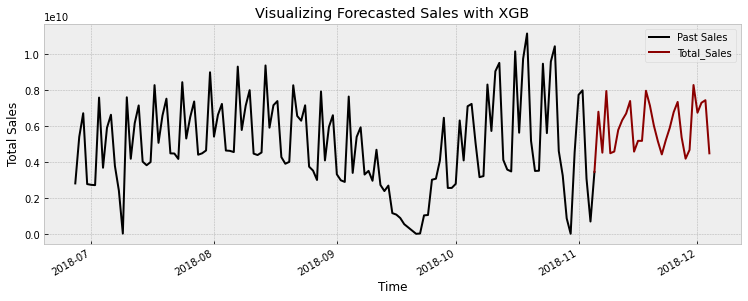

In [74]:
#visualizing the forecasted sales
df = df2[['Total_Sales']].loc[:forecast_date]
df_forecast = df2[['Total_Sales']].loc[forecast_date:]
forecast_plot(df, df_forecast,'XGB')

# 9. Conclusion


In [75]:
result

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,Simple Moving Average,1.340669e+19,3.661515e+09,3.179639e+09,-0.387093
1,Time Series,Weighted Moving Average,1.711698e+19,4.137267e+09,3.139920e+09,-0.770970
2,Time Series,ARIMA,7.127937e+18,2.669820e+09,2.131719e+09,0.553647
3,Time Series,SARIMAX,1.934418e+19,4.398201e+09,3.374759e+09,-0.211337
4,Machine Learning,RFR(n_estimators=100),7.716221e+18,2.777809e+09,2.402536e+09,0.201658
5,Machine Learning,RFR(n_estimators=200),7.470949e+18,2.733304e+09,2.339553e+09,0.227035
6,Machine Learning,RFR(n_estimators=300),7.442448e+18,2.728085e+09,2.335873e+09,0.229984
7,Machine Learning,XGBRegressor,8.418149e+18,2.901405e+09,2.344283e+09,0.129035
8,Machine Learning,Linear Regression,9.677848e+18,3.110924e+09,2.918928e+09,-0.001297


Although, the Machine Learning models tend to fit the data better than the time series models, we are going to look at the **'MSE'** and **'R^2'** metrics to finally evaluate the best model. 

The '**MSE'** tells us how close the points are to the regression line. It calculates the statistical error.

The **'R^2'** gives us the strength of the relationship between the model and the dependent variables.  
The ideal range of R-squared can take values in the range (0, 1]. Whenever **R^2** is **negative** it means that the model fits the data worse than a horizontal line  in a nonlinear function. Hence, models with a **negative R^2** are excluded for the consideration of model selection.

Although according to an organisations needs, different metric such as the 'AIC'and 'BIC' can also be considered. These metrics give us the trade off between the model fit and complexity of the model.

Even though the **'ARIMA' model** seems to be a bit more complex than the ML models, with the highest 'R^2' value (0.55 - pretty good for real world problems) and the lowest 'MSE' **is considered to be the best model** for forecasting Total Sales regarding this cinema_ticket dataset.

The power of Forecasting sales in the film industry allows the makers to allocate resources accordingly, make changes to their movies for an optimal experience and also enables marketing teams to strategize for  further growth.
